In [78]:
import pandas as pd
import numpy as np
import joblib
import os

from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from dotenv import load_dotenv

from datetime import date
from datetime import timedelta

import yfinance as yf

%matplotlib inline
import matplotlib.pyplot as plt

from openbb_terminal.sdk import openbb

In [50]:
def get_stock_data(symbols, start_date, end_date):
    stock_data = {}
    for symbol in symbols:
        stock = yf.download(symbol, start=start_date, end=end_date)
        stock_data[symbol] = stock
    return stock_data

# Setup for end_date, calling on last full day.
today = date.today()

# Getting the initial date ranges for review
start_date = date(2013,1,1)
end_date = today - timedelta(days = 1)

symbols = ['AAPL','MSFT','AMZN']

stock_data = get_stock_data(symbols, start_date, end_date)

for symbol in symbols:
    stock = stock_data[symbol]
    
stock

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-01-02,12.804000,12.905000,12.663000,12.865500,12.865500,65420000
2013-01-03,12.863500,13.044000,12.818500,12.924000,12.924000,55018000
2013-01-04,12.879000,12.990000,12.832500,12.957500,12.957500,37484000
2013-01-07,13.148500,13.486500,13.133500,13.423000,13.423000,98200000
2013-01-08,13.353500,13.449000,13.178500,13.319000,13.319000,60214000
...,...,...,...,...,...,...
2023-04-10,100.959999,102.199997,99.570000,102.169998,102.169998,37261200
2023-04-11,100.800003,101.000000,99.010002,99.919998,99.919998,60417800
2023-04-12,100.400002,100.510002,97.709999,97.830002,97.830002,56735000


In [51]:
def generate_signals(df, short_window=30, long_window=120):
    # Compute the Exponential Moving Averages
    df['EMA_short'] = df['Close'].ewm(span=short_window, adjust=False).mean()
    df['EMA_long'] = df['Close'].ewm(span=long_window, adjust=False).mean()
    
    # Initialize the Signal column
    df['Signal'] = 0.0
    
    # When the short EMA is above the long EMA, generate a signal to buy long
    df.loc[(df['EMA_short'] >= df['EMA_long']), 'Signal'] = 1
    
    # When the short EMA is below the long EMA, generate a signal to sell short
    df.loc[(df['EMA_short'] < df['EMA_long']), 'Signal'] = -1
    
    # Calculate the daily returns and add them to the DataFrame
    df['Returns'] = df['Close'].pct_change()
    df = df.dropna()
    
    # Calculate the strategy returns and add them to the DataFrame
    df['StrategyReturns'] = df['Returns'] * df['Signal'].shift()
    
    return df


def preprocess_data(X_train, X_test):
    # Create a StandardScaler instance
    scaler = StandardScaler()

    # Apply the scaler model to fit the X_train data
    X_scaler = scaler.fit(X_train)

    # Transform the X_train and X_test DataFrames using the X_scaler
    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)

    joblib.dump(X_scaler, 'X_scaler.joblib')
    
    return X_train_scaled, X_test_scaled


def train_model(X_train, y_train):
    # Instantiate the SVC classifier model
    svm_model = SVC(kernel='rbf', C=1, gamma=0.1)
 
    # Fit the model to the data using the training data
    svm_model = svm_model.fit(X_train, y_train)
    
    joblib.dump(svm_model, 'svm_model.joblib')

    return svm_model


def evaluate_model(model, X_test, y_test):
    # Use the testing data to make the model predictions
    y_pred = model.predict(X_test)
    
    # Use a classification report to evaluate the model using the predictions and testing data
    report = classification_report(y_test, y_pred)
    
    return report


def generate_trading_signals(df, model, X_scaler):
    # Select the last row of the DataFrame and drop the Signal column
    last_row = df.iloc[-1].drop('Signal')

    # Shift the last row and convert it to a DataFrame
    X = pd.DataFrame(last_row).T

    # Scale the features using the X_scaler
    X_scaled = X_scaler.transform(X)

    # Use the model to predict the signal for the next day
    signal = model.predict(X_scaled)[0]

    # Return the predicted signal
    return signal


def backtest_strategy(df, model, X_scaler):
    # Generate trading signals using the model and X_scaler
    df['Signal'] = df.apply(lambda x: generate_trading_signals(df[:x.name], model, X_scaler), axis=1)

    # Calculate the daily returns and add them to the DataFrame
    df['Returns'] = df['Close'].pct_change()

    # Calculate the strategy returns and add them to the DataFrame
    df['StrategyReturns'] = df['Returns'] * df['Signal'].shift()

    # Calculate the cumulative returns and add them to the DataFrame
    df['CumulativeReturns'] = (1 + df['StrategyReturns']).cumprod()

    # Calculate the annualized return
    annualized_return = (df['CumulativeReturns'][-1]) ** (252/len(df.index)) - 1

    # Calculate the annualized volatility
    annualized_volatility = df['Returns'].std() * np.sqrt(252)

    # Calculate the Sharpe Ratio
    sharpe_ratio = annualized_return / annualized_volatility

    return df, annualized_return, annualized_volatility, sharpe_ratio

In [52]:
signals_df = generate_signals(stock).dropna()
signals_df

C:\Users\Elias\AppData\Local\Temp\ipykernel_48348\3204791354.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['StrategyReturns'] = df['Returns'] * df['Signal'].shift()


,Open,High,Low,Close,Adj Close,Volume,EMA_short,EMA_long,Signal,Returns,StrategyReturns
Date,,,,,,,,,,,
2013-01-04,12.879000,12.990000,12.832500,12.957500,12.957500,37484000,12.874967,12.867972,1.0,0.002592,0.002592
2013-01-07,13.148500,13.486500,13.133500,13.423000,13.423000,98200000,12.910324,12.877146,1.0,0.035925,0.035925
2013-01-08,13.353500,13.449000,13.178500,13.319000,13.319000,60214000,12.936690,12.884449,1.0,-0.007748,-0.007748
2013-01-09,13.408500,13.475000,13.270000,13.317500,13.317500,45312000,12.961258,12.891607,1.0,-0.000113,-0.000113
2013-01-10,13.427000,13.437000,13.115000,13.267000,13.267000,57268000,12.980984,12.897812,1.0,-0.003792,-0.003792
...,...,...,...,...,...,...,...,...,...,...,...
2023-04-10,100.959999,102.199997,99.570000,102.169998,102.169998,37261200,98.951656,100.833248,-1.0,0.001078,-0.001078
2023-04-11,100.800003,101.000000,99.010002,99.919998,99.919998,60417800,99.014130,100.818153,-1.0,-0.022022,0.022022
2023-04-12,100.400002,100.510002,97.709999,97.830002,97.830002,56735000,98.937734,100.768762,-1.0,-0.020917,0.020917


In [53]:
# Split the data into training and testing sets
train_size = int(len(signals_df) * 0.8)
train_data = signals_df[:train_size]
test_data = signals_df[train_size:]

# Preprocess the training and testing data
X_train, y_train = train_data.drop(['Signal'], axis=1), train_data['Signal']
X_test, y_test = test_data.drop(['Signal'], axis=1), test_data['Signal']
X_train_scaled, X_test_scaled = preprocess_data(X_train, X_test)

# Train the model
model = train_model(X_train_scaled, y_train)

In [54]:
# Evaluate the model
report = evaluate_model(model, X_test_scaled, y_test)
print(report)

              precision    recall  f1-score   support

        -1.0       1.00      0.56      0.72       335
         1.0       0.55      1.00      0.71       183

    accuracy                           0.72       518
   macro avg       0.78      0.78      0.72       518
weighted avg       0.84      0.72      0.72       518



In [55]:
# Generate trading signals for the entire DataFrame
X_scaler = StandardScaler().fit(X_train)
signals_df['Signal'] = signals_df.apply(lambda x: generate_trading_signals(signals_df[:x.name], model, X_scaler), axis=1)

In [56]:
# Backtest the strategy
backtest_results = backtest_strategy(signals_df, model, X_scaler)
print(backtest_results)

(                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2013-01-04   12.879000   12.990000   12.832500   12.957500   12.957500   
2013-01-07   13.148500   13.486500   13.133500   13.423000   13.423000   
2013-01-08   13.353500   13.449000   13.178500   13.319000   13.319000   
2013-01-09   13.408500   13.475000   13.270000   13.317500   13.317500   
2013-01-10   13.427000   13.437000   13.115000   13.267000   13.267000   
...                ...         ...         ...         ...         ...   
2023-04-10  100.959999  102.199997   99.570000  102.169998  102.169998   
2023-04-11  100.800003  101.000000   99.010002   99.919998   99.919998   
2023-04-12  100.400002  100.510002   97.709999   97.830002   97.830002   
2023-04-13   98.949997  102.570000   98.709999  102.400002  102.400002   
2023-04-14  102.070000  103.199997  101.110001  102.510002  102.510002   

              Volume  EMA_short    E

In [57]:
# Download the SPY data
spy_data = get_stock_data(['SPY'], start_date, end_date)['SPY']
spy_returns = spy_data['Close'].pct_change()

[*********************100%***********************]  1 of 1 completed


In [58]:
strategy_returns = signals_df['StrategyReturns']
cumulative_strategy_returns = strategy_returns.cumsum()
cumulative_spy_returns = spy_returns.cumsum()

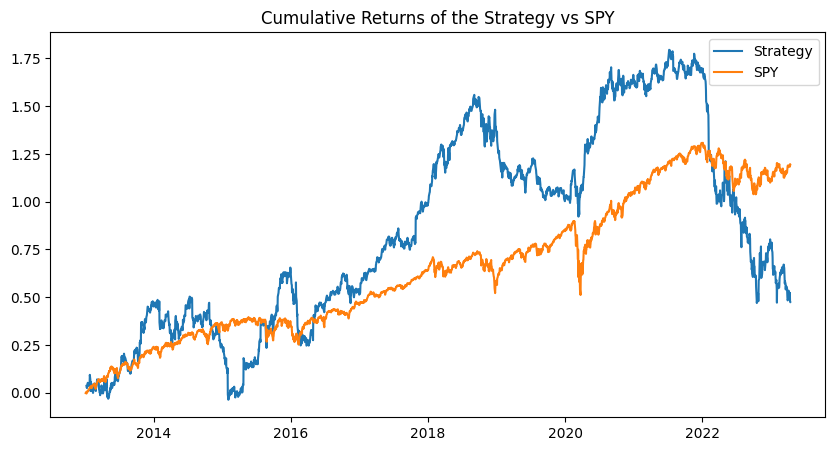

In [59]:
# Plot the cumulative returns of the strategy and SPY
plt.figure(figsize=(10, 5))
plt.plot(cumulative_strategy_returns, label='Strategy')
plt.plot(cumulative_spy_returns, label='SPY')
plt.legend()
plt.title('Cumulative Returns of the Strategy vs SPY')
plt.show()

In [83]:
openbb.stocks.load(symbol= 'AAPL')

Loading Daily data for AAPL with starting period 2020-04-13.

,Open,High,Low,Close,Adj Close,Volume
date,,,,,,
2020-04-13,67.077499,68.425003,66.457497,68.312500,66.980797,131022800
2020-04-14,70.000000,72.062500,69.512497,71.762497,70.363510,194994800
2020-04-15,70.599998,71.582497,70.157501,71.107498,69.721291,131154400
2020-04-16,71.845001,72.050003,70.587502,71.672501,70.275291,157125200
2020-04-17,71.172501,71.737503,69.214996,70.699997,69.321739,215250000
...,...,...,...,...,...,...
2023-04-10,161.419998,162.029999,160.080002,162.029999,162.029999,47716900
2023-04-11,162.350006,162.360001,160.509995,160.800003,160.800003,47644200
2023-04-12,161.220001,162.059998,159.779999,160.100006,160.100006,50133100
